<a href="https://colab.research.google.com/github/cdcmx2020a/group_a_twitter/blob/master/lesson1_pandas_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install two libraries that do not come with colab:
!pip install pandas geopandas unidecode scipy sktime pmdarima

In [19]:
# import (or make available) some libraries:

# pandas and geopandas, to load and store data
import pandas as pd 
import geopandas as gpd

# pyplot, to visualize
import matplotlib.pyplot as plt

# numpy, for math and matrices
import numpy as np

# ARIMA, a basic time series forecasting model 
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting.forecasting import plot_ys


# similar to print(), but better formatting in notebooks
from IPython.display import display

# unidecode, to replace characters with accents 
from unidecode import unidecode 

# spline, for smoothing out spiky data
from scipy.interpolate import make_interp_spline, BSpline


## Loading and displaying time series data

In [3]:
# pd.read_csv reads a CSV file and turns it into a *DataFrame*
cases = pd.read_csv(
    'https://raw.githubusercontent.com/cdcmx2020a/group_a_twitter/master/covid_data/cases_mexico_transformed.csv'
)

# head(5) returns the first 5 rows of a DataFrame
display(cases.head(5))
display(cases.tail(5))

# nombre: municipality
# date: days since 01-01-2020
# cases: number of cases per day 

,cve_ent,poblacion,nombre,date,cases
0,16046,15290,Juarez,11,0
1,16047,22358,Jungapeo,11,0
2,16048,5862,Lagunillas,11,0
3,16049,18769,Madero,11,0
4,5035,744247,Torreon,11,0


,cve_ent,poblacion,nombre,date,cases
476653,32053,13945,Villa Gonzalez Ortega,204,0
476654,32054,20177,Villa Hidalgo,204,0
476655,32055,31804,Villanueva,204,0
476656,32056,155533,Zacatecas,204,0
476657,32058,2855,Santa Maria de la Paz,204,0


In [4]:
# look at just 'nombre' and 'cases' columns
display(cases[['nombre', 'date', 'cases']].head(5))
cases = cases[['nombre', 'date', 'cases']]
# display(cases.head(5))

,nombre,date,cases
0,Juarez,11,0
1,Jungapeo,11,0
2,Lagunillas,11,0
3,Madero,11,0
4,Torreon,11,0


In [5]:
# characters with accents are hard to code with:
display(cases.query('nombre == "Magdalena Penasco"'))
print('--------')
print('Magdalena Peñasco', 'turns into', unidecode('Magdalena Peñasco'))
print('--------')
cases['nombre'] = cases['nombre'].apply(unidecode)
# display(cases.query('nombre == "Magdalena Penasco"'))

,nombre,date,cases


--------
Magdalena Peñasco turns into Magdalena Penasco
--------


In [6]:
# calculate the total number of cases in each municipality
cases_total_muni = (cases[['nombre', 'cases']]           # select nombre and cases columns
                    .groupby('nombre', as_index=False)   # group rows by nombre
                    .sum())                              # add rows within a group
display(cases_total_muni.head(5))

# Q: how do we calculate total number of cases each day?
# cases_total_date = ?

,nombre,cases
0,Abala,3
1,Abasolo,104
2,Abejones,2
3,Acacoyagua,3
4,Acajete,72


In [7]:
def split_by_municipality(cases):
    # returns a DataFrame with a separate column for each muncipality
    cases_split = (cases[['nombre', 'date', 'cases']]
                   .groupby(['nombre', 'date'], as_index=False)['cases'].sum()
                   .pivot(index='date', columns='nombre', values='cases')
                   .fillna(0)
                   .sort_index())
    return cases_split 

cases_split = split_by_municipality(cases)
# Q: how do we look at cases_split?

## Visualizing time series

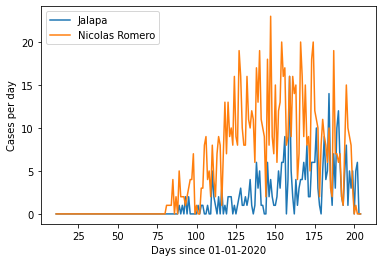

In [8]:
# Q: write comments (guess if you don't know) for each line of this function:
def plot_muni(cases_split, muni):
    muni_cases = cases_split[muni]
    dates = cases_split.index 
    plt.plot(
        dates,
        muni_cases,
        label=muni
    )


plot_muni(cases_split, 'Jalapa')
plot_muni(cases_split, 'Nicolas Romero')
plt.xlabel('Days since 01-01-2020')
plt.ylabel('Cases per day')
plt.legend()
plt.show()

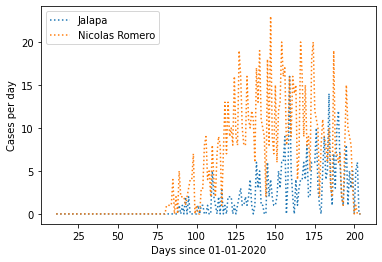

In [9]:
# Documentation: https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.pyplot.scatter.html
# Challenge: make the plot look different! 
def plot_muni_new(cases_split, muni):
    muni_cases = cases_split[muni]
    dates = cases_split.index 
    plt.plot(
        dates,
        muni_cases,
        label=muni,
        linestyle=':'
    )

plot_muni_new(cases_split, 'Jalapa')
plot_muni_new(cases_split, 'Nicolas Romero')
plt.xlabel('Days since 01-01-2020')
plt.ylabel('Cases per day')
plt.legend()
plt.show()

## What's the point?

In [10]:
# Q: What kind of questions can we answer using this data?

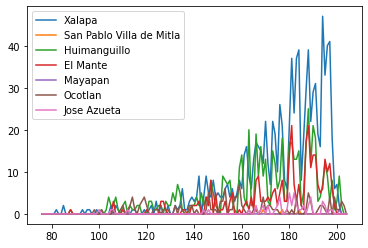

In [11]:
cases_split_drop = cases_split.query('date > 75')
[plot_muni(cases_split_drop, c) for c in 
 ['Xalapa', 'San Pablo Villa de Mitla', 'Huimanguillo',
  'El Mante', 'Mayapan', 'Ocotlan', 'Jose Azueta']]

plt.legend()
plt.show()

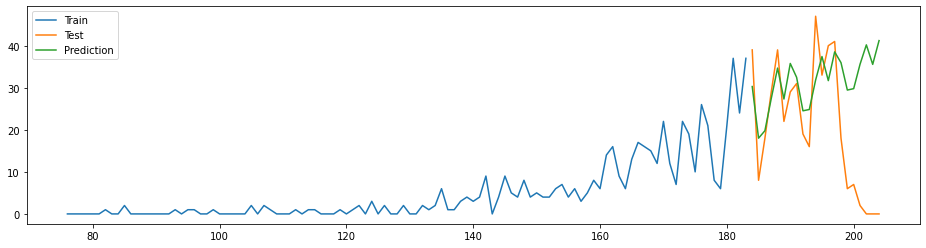

In [26]:
y_train, y_test = temporal_train_test_split(cases_split_drop['Xalapa'], test_size=21)
forecaster = AutoARIMA(sp=7, suppress_warnings=True)
forecaster.fit(y_train)
x_test = np.arange(len(y_test)) + 1
y_pred = forecaster.predict(x_test)
plot_ys(y_train, y_test, y_pred, labels=["Train", "Test", 'Prediction'])
plt.show()

# Q: What problems in the data make this difficult?

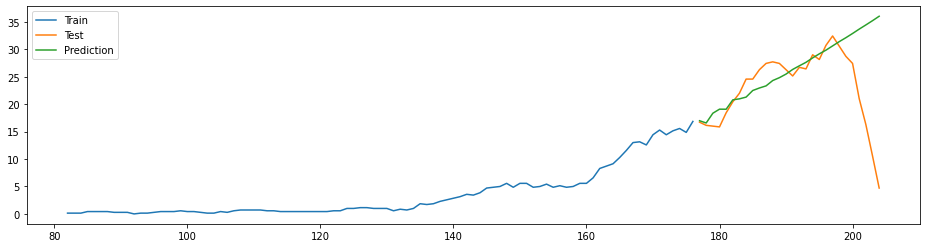

In [24]:
smoothened = cases_split_drop['Xalapa'].rolling(window=7).mean()[6:]
y_train, y_test = temporal_train_test_split(smoothened, test_size=28)
forecaster = AutoARIMA(sp=7, suppress_warnings=True)
forecaster.fit(y_train)
x_test = np.arange(len(y_test)) + 1
y_pred = forecaster.predict(x_test)
plot_ys(y_train, y_test, y_pred, labels=["Train", "Test", 'Prediction'])
plt.show()

## Homework

The first day's homework is about three things:


1.   Reading documentation and learning `pandas` and `matplotlib`
2.   Playing with the time series data
3.   Making some interesting visualizations!

Go through these tutorials: [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) and [PyPlot](https://matplotlib.org/tutorials/introductory/pyplot.html). Do the examples and see what happens.

Based on these examples (or anything else you find!), come up with *one* new visualization of the COVID-19 case rate data. You are welcome to use any other libraries, methods, or even other data you can find. 

On Monday, you will show us your visualization and explain it in 30-60s. We'll vote on our favorite!

My entry for the contest:

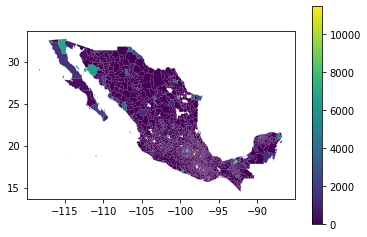

